In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, balanced_accuracy_score, confusion_matrix
from label_propagation import *

%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
adata_cite = anndata.read_h5ad(os.path.join('data', 'citeseq-adata-jolene_export.h5ad'))
adata_xen = anndata.read_h5ad(os.path.join('data', 'xenium-adata-jolene_export.h5ad'))


In [3]:
adata_cite

AnnData object with n_obs × n_vars = 106315 × 3342
    obs: 'donor_id', 'sample_id', 'tissue', 'n_genes_by_counts', 'total_counts', 'celltype_hires', 'celltype_lores', 'celltype_lvl025', 'celltype_lvl1'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_hires_colors', 'dendrogram_celltype_hires', 'dendrogram_leiden_wnn', 'hvg', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_id_colors', 'tissue_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata_xen

AnnData object with n_obs × n_vars = 355814 × 474
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'celltype_lvl1', 'celltype_lvl025', 'cell_area', 'tissue', 'Selection', 'core'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'celltype_colors', 'celltype_lvl2_colors', 'dendrogram_celltype_lvl2', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial_neighbors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
adata_cite = anndata.read_h5ad(os.path.join('data', 'citeseq-adata-jolene_export.h5ad'))
adata_xen = anndata.read_h5ad(os.path.join('data', 'xenium-adata-jolene_export.h5ad'))

labels_key = 'celltype_lvl0'
shared_labels = list(set(np.unique(adata_cite.obs[labels_key])).intersection(np.unique(adata_xen.obs[labels_key])))

## subset based on shared cell types, save object, and run integration 
adata_cite = adata_cite[np.isin(adata_cite.obs[labels_key], shared_labels)]
#adata_cite.write_h5ad(os.path.join('data', labels_key, f'adata_cite.h5ad'))

adata_xen = adata_xen[np.isin(adata_xen.obs[labels_key], shared_labels)]
#adata_xen.write_h5ad(os.path.join('data',labels_key, f'adata_xen.h5ad'))

In [3]:
## load in predicted values
umap_coords = pd.read_csv(os.path.join('data', labels_key, 'umap_coords.csv'), index_col = 0)
embedding = pd.read_csv(os.path.join('data', labels_key, 'norm_factors.csv'), index_col = 0)
W = sc.read_mtx(os.path.join('data', labels_key, 'SNN.mtx'))
W = W.X

In [4]:
cite_labels = pd.DataFrame(adata_cite.obs[labels_key])
cite_labels.index = ['citeseq'+'_'+i for i in cite_labels.index]

xen_labels = pd.DataFrame(adata_xen.obs[labels_key])
xen_labels.index = ['xenium'+'_'+i for i in xen_labels.index]

labels = pd.concat([cite_labels, xen_labels], axis = 0)

In [5]:
adata_pred = anndata.AnnData(embedding)
adata_pred.obs[labels_key] = labels

adata_pred.obs['modality'] = np.nan
adata_pred.obs.loc[adata_pred.obs_names[adata_pred.obs_names.str.contains('xenium')], 'modality'] = 'Xenium'
adata_pred.obs.loc[adata_pred.obs_names[adata_pred.obs_names.str.contains('citeseq')], 'modality'] = 'CITE-seq'

adata_pred.obsm['X_umap'] = umap_coords.values

/var/folders/kb/2tk0dg0x1jl0sdpds29dqln40000gn/T/ipykernel_87270/2140585498.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Xenium' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_pred.obs.loc[adata_pred.obs_names[adata_pred.obs_names.str.contains('xenium')], 'modality'] = 'Xenium'


In [ ]:
metrics = ['F1', 'balanced_accuracy', 'auc', 'precision', 'accuracy']
train_id = 'CITE-seq'
test_id = 'Xenium'
train_index = np.where(adata_pred.obs['modality'] == train_id)[0]
test_index = np.where(adata_pred.obs['modality'] == test_id)[0]

In [7]:
le = LabelEncoder()
y = le.fit_transform(adata_pred.obs[labels_key]).astype(int)
X = adata_pred.X.copy()
n_nodes = np.shape(y)[0]
n_classes = len(np.unique(adata_pred.obs[labels_key]))
y_bin = label_binarize(y, classes=list(np.arange(0, n_classes)))

y_t = np.full(n_nodes, -1.)
y_t[train_index] = y[train_index].copy()
label_propagation = LabelPropagation(W)
label_propagation.fit(y_t,  max_iter = 500)
predicted_labels, predicted_scores, _ = label_propagation.predict_labels()

metric_values = []
for m in metrics:
    if m == 'F1':
        metric_values.append(f1_score(y_true = y[test_index], y_pred = predicted_labels[test_index], average = 'weighted'))
    elif m == 'balanced_accuracy':
        metric_values.append(balanced_accuracy_score(y_true = y[test_index], y_pred = predicted_labels[test_index]))
    elif m == 'auc':
        if n_classes == 2: #binary 
            #prob should be of the class with the greater label ie 1
            metric_values.append(roc_auc_score(y_bin[test_index], predicted_scores[test_index, 1], multi_class = 'ovr'))
        else: #multiclass
            metric_values.append(roc_auc_score(y_bin[test_index, :], predicted_scores[test_index, :], multi_class = 'ovr'))
    elif m =='precision':
        metric_values.append(precision_score(y_true = y[test_index], y_pred = predicted_labels[test_index], average = 'weighted'))
    elif m =='accuracy':
        metric_values.append(accuracy_score(y_true = y[test_index], y_pred = predicted_labels[test_index]))
scores_df = pd.DataFrame(metric_values, index = metrics, columns = ['metrics'])
scores_df.to_csv(f'{test_id}_metrics.csv')

The method stopped after 169 iterations, variation=0.0010.


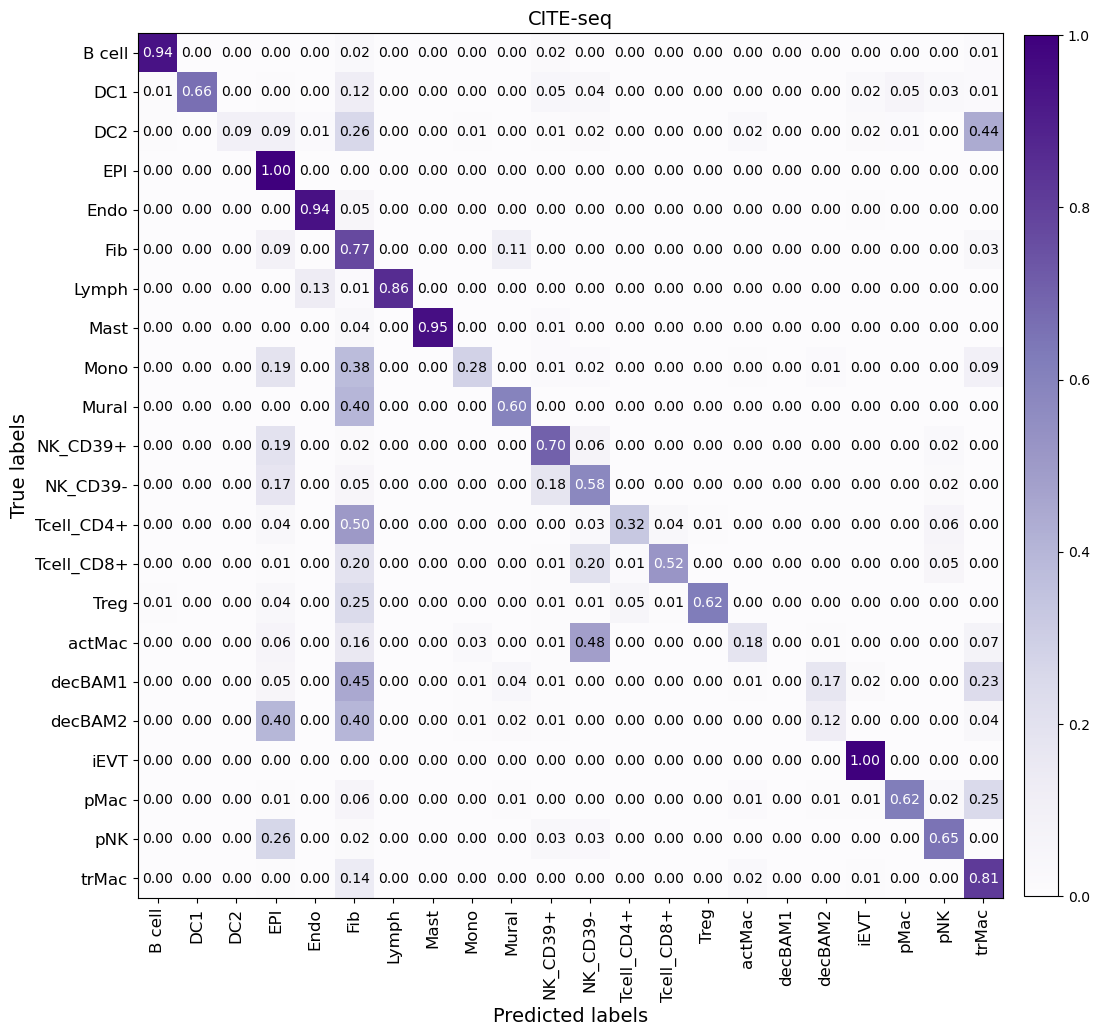

In [8]:
true_labels = y[test_index]
pred_labels = predicted_labels[test_index]
cm = confusion_matrix(true_labels, pred_labels)
class_names = le.classes_
plot_confusion_matrix_imshow(cm, class_names, normalize=True, fontsize = 12, title=test_id, cmap='Purples', filename_save = f'{test_id}_confusion_matrix', figsize = (12,12))

In [9]:
adata_pred.obs['predicted_labels'] = np.nan
adata_pred.obs.loc[adata_pred.obs_names[test_index], 'predicted_labels'] = pd.Series(predicted_labels[test_index]).map(dict(zip(np.unique(predicted_labels[test_index]), le.classes_ ))).values

/var/folders/kb/2tk0dg0x1jl0sdpds29dqln40000gn/T/ipykernel_87270/499591429.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Treg' 'trMac' 'trMac' ... 'Mural' 'Tcell_CD4+' 'Fib']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata_pred.obs.loc[adata_pred.obs_names[test_index], 'predicted_labels'] = pd.Series(predicted_labels[test_index]).map(dict(zip(np.unique(predicted_labels[test_index]), le.classes_ ))).values


In [10]:
_, axes = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw={'hspace': 0.45, 'wspace': 0.4, 'bottom':0.15})
sc.pl.umap(adata_pred[adata_pred.obs['modality'] == 'Xenium'], color = labels_key, ax = axes.flatten()[0], show = False, title = 'Xenium')
sc.pl.umap(adata_pred[adata_pred.obs['modality'] == 'CITE-seq'], color = labels_key, ax = axes.flatten()[1], show = False, title = 'CITE-seq', save = 'integrated_uinmf_umap')

/Users/jolene/miniconda3/envs/venv_quiche/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/Users/jolene/miniconda3/envs/venv_quiche/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/jolene/miniconda3/envs/venv_quiche/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


<Axes: title={'center': 'CITE-seq'}, xlabel='UMAP1', ylabel='UMAP2'>

In [11]:
_, axes = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw={'hspace': 0.45, 'wspace': 0.4, 'bottom':0.15})
sc.pl.umap(adata_pred[adata_pred.obs['modality'] == test_id], color = labels_key, ax = axes.flatten()[0], show = False, title = f'True ({test_id})')
sc.pl.umap(adata_pred[adata_pred.obs['modality'] == test_id], color = 'predicted_labels', ax = axes.flatten()[1], show = False, title = f'Predicted ({test_id})', save = f'true_predicted_{test_id}_umap')

/Users/jolene/miniconda3/envs/venv_quiche/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/jolene/miniconda3/envs/venv_quiche/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/jolene/miniconda3/envs/venv_quiche/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/jolene/miniconda3/envs/venv_quiche/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


<Axes: title={'center': 'Predicted (CITE-seq)'}, xlabel='UMAP1', ylabel='UMAP2'>